## Load libraries

In [143]:
""" Basics """
import os
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

""" MCMC """
import pymc3 as pm
import theano.tensor as tt

""" Web """
import requests
from lxml import html, etree

""" Plotting """
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.core.pylabtools import figsize

## Retrieve top players

In [144]:
'''
xpath  = """//*[@class="format_cell detail_list_player"]/a[2]/text()"""
page   = requests.get("https://www.esportsearnings.com/games/151-starcraft-ii/top-players")
tree   = html.fromstring(page.content)
top100 = tree.xpath(xpath)
top9  = top100[:9]
print(top9)
'''

#top9 = ['Maru', 'Rogue', 'sOs', 'TY', 'INnoVation', 'Life'] #, 'MC', 'Serral', 'Stats'
top9 = ['Maru', 'Rogue', 'sOs', 'TY', 'Classic', 'Zest', 'Dark', 'Stats']

In [186]:
xpath = "//tr/td[@align = 'left']/a/text()"
page = requests.get("https://liquipedia.net/starcraft2/2017_StarCraft_II_World_Championship_Series_Korea/Standings")
tree = html.fromstring(page.content)
top  = tree.xpath(xpath)
top9 = top[:8]

In [187]:
top9

['Stats', 'INnoVation', 'Dark', 'soO', 'TY', 'GuMiho', 'herO', 'Rogue']

## Load and clean match data

In [188]:
data = pd.read_csv('sc2-matches-history.csv')
print("Rows: {}".format(len(data)))
print("Unique players: {}".format(len(data['player_1'].unique())))
data

Rows: 374794
Unique players: 1856


,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
0,09/19/2016,MC,[loser],0–2,Stats,[winner],P,P,LotV,online
1,09/19/2016,MC,[winner],2–1,NaTuRal,[loser],P,T,LotV,online
2,09/19/2016,MC,[loser],1–2,Dark,[winner],P,Z,LotV,online
3,09/13/2016,MC,[loser],0–2,INnoVation,[winner],P,T,LotV,online
4,08/27/2016,MC,[loser],0–1,TRUE,[winner],P,Z,LotV,online
5,07/17/2016,MC,[loser],0–1,Cure,[winner],P,T,LotV,offline
6,07/16/2016,MC,[winner],1–0,Super,[loser],P,P,LotV,offline
7,07/16/2016,MC,[winner],1–0,aLive,[loser],P,T,LotV,offline
8,07/16/2016,MC,[winner],1–0,Curious,[loser],P,Z,LotV,offline
9,07/06/2016,MC,[loser],0–2,Zest,[winner],P,P,LotV,offline


In [189]:
data = data[data['player_1'].isin(top9)]
data = data[data['player_2'].isin(top9)]
assert(len(data['player_1'].unique()) == len(top9))
assert(len(data['player_2'].unique()) == len(top9))

def extract_score(row, player):
    if player == 1:
        score = row[0]
    elif player == 2:
        score = row[2]
    return(int(score))

data['score_1'] = data['score'].apply(lambda x: extract_score(x, 1))
data['score_2'] = data['score'].apply(lambda x: extract_score(x, 2))

data.drop(['player_1_match_status', 
           'score', 
           'player_2_match_status', 
           'addon', 
           'tournament_type'], 
          axis=1, inplace=True)

In [190]:
data.match_date = pd.to_datetime(data.match_date)
data = data.sort_values(by = ['match_date'])

In [191]:
players      = data['player_1'].unique()
players      = pd.DataFrame(players, columns=['players'])
players['i'] = players.index
playerd = players.to_dict()

In [192]:
playerd = playerd['players']
playerd

{0: 'INnoVation',
 1: 'soO',
 2: 'herO',
 3: 'Rogue',
 4: 'TY',
 5: 'Stats',
 6: 'GuMiho',
 7: 'Dark'}

In [193]:
data = pd.merge(data, players, left_on='player_1', right_on='players', how='left')
data = data.rename(columns = {'i': 'i_player_1'}).drop('players', 1)
data = pd.merge(data, players, left_on='player_2', right_on='players', how='left')
data = data.rename(columns = {'i': 'i_player_2'}).drop('players', 1)
data.head(20)

,match_date,player_1,player_2,player_1_race,player_2_race,score_1,score_2,i_player_1,i_player_2
0,2012-07-15,INnoVation,soO,T,Z,0,1,0,1
1,2012-07-15,soO,INnoVation,Z,T,1,0,1,0
2,2012-07-19,herO,INnoVation,P,T,1,2,2,0
3,2012-07-19,INnoVation,herO,T,P,2,1,0,2
4,2012-08-12,Rogue,soO,Z,Z,1,0,3,1
5,2012-08-12,soO,Rogue,Z,Z,0,1,1,3
6,2012-09-09,soO,herO,Z,P,0,1,1,2
7,2012-09-09,herO,soO,P,Z,1,0,2,1
8,2012-10-22,TY,soO,T,Z,1,4,4,1
9,2012-10-22,soO,TY,Z,T,4,1,1,4


In [194]:
dates = [min(data.match_date), "2014-01-01", "2015-01-01", "2016-01-01"]
for date in dates:
    print("GEQ {}: {}".format(date, len(data[data['match_date'] >= pd.to_datetime(date)])))
data = data[data['match_date'] >= pd.to_datetime(dates[3])]

GEQ 2012-07-15 00:00:00: 975
GEQ 2014-01-01: 905
GEQ 2015-01-01: 789
GEQ 2016-01-01: 661


In [195]:
def plot_multi(player, data, i, ax):
    sumdata = data.copy()
    sumdata = sumdata[sumdata['player_1'] == player]
    sumdata['cumsum_1'], sumdata['cumsum_2'] = sumdata['score_1'].cumsum(), sumdata['score_2'].cumsum()
    ax[i].plot(sumdata['cumsum_1'], sumdata['cumsum_2'])
    ax[i].set_title(player)
    ax[i].set_xlabel('Attack')
    ax[i].set_ylabel('Defense')
    del(sumdata)

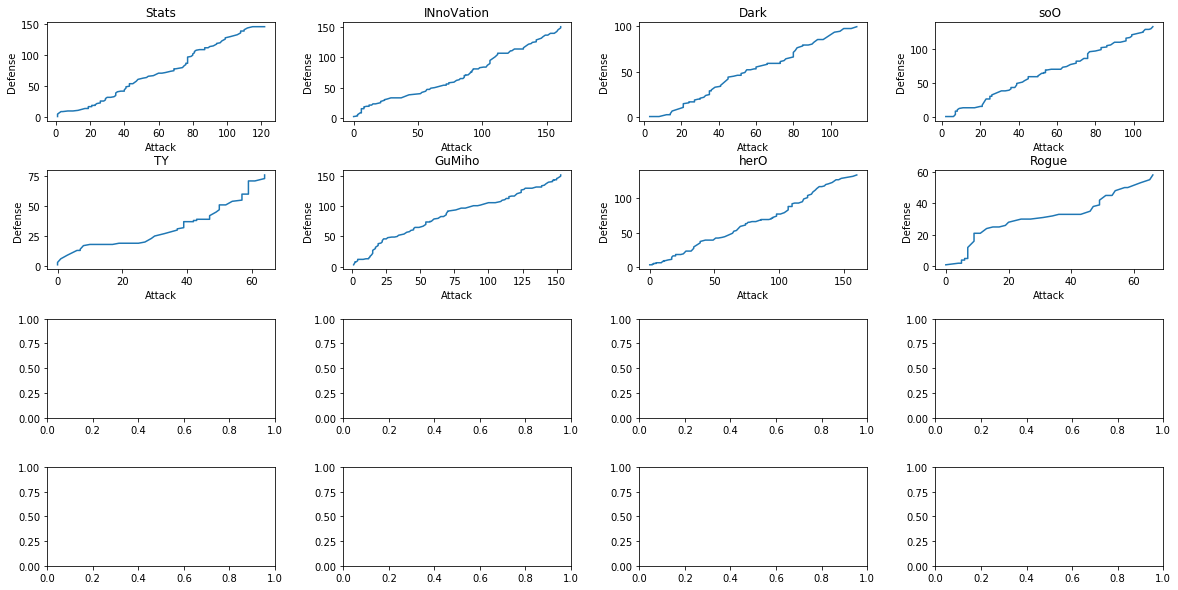

In [196]:
fig, axs = plt.subplots(4,4, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
i = 0

for player in top9:
    plot_multi(player, data, i, axs)
    i += 1
    
fig.savefig('subplot_2.png')

In [197]:
def print_rel(player, data):
    t = len(data)
    k = len(data[data['player_1'] == player])
    print("{}:\t {}".format(player, k/t))
    
for player in top9:
    print_rel(player, data)

Stats:	 0.14977307110438728
INnoVation:	 0.15279878971255673
Dark:	 0.11800302571860817
soO:	 0.12405446293494705
TY:	 0.08169440242057488
GuMiho:	 0.15431164901664146
herO:	 0.15128593040847202
Rogue:	 0.0680786686838124


In [198]:
observed_player1_score = data.score_1.values
observed_player2_score = data.score_2.values
player_1               = data.i_player_1.values
player_2               = data.i_player_2.values
n_players              = len(data.player_1.unique())
n_games                = len(player_1)
print("{} players, {} games".format(n_players, n_games))

8 players, 661 games


In [199]:
g = data.groupby('i_player_1')
p1_start = np.log(g.score_1.mean())
g = data.groupby('i_player_2')
p2_start = np.log(g.score_1.mean())
p1_start, p2_start

(i_player_1
 0    0.466284
 1    0.293761
 2    0.470004
 3    0.382992
 4    0.169899
 5    0.208901
 6    0.405465
 7    0.379490
 Name: score_1, dtype: float64, i_player_2
 0    0.402159
 1    0.483630
 2    0.302720
 3    0.253781
 4    0.341749
 5    0.385262
 6    0.398908
 7    0.238411
 Name: score_1, dtype: float64)

In [200]:
with pm.Model() as base_model:
    # global model parameters
    #mu_att     = pm.Normal('mu_att', 0, 0.0001)  # Distribution of mean, attack
    #mu_def     = pm.Normal('mu_def', 0, 0.0001)  # Distribution of mean, defense
    tau_att    = pm.Gamma('tau_att', 0.1, 0.1) # Distribution of stdev, attack
    tau_def    = pm.Gamma('tau_def', 0.1, 0.1) # Distribution of stdev, defense
    #intercept  = pm.Normal('intercept', 0, 0.0001)            # Tuneable intercept

    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = 0, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = 0, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(atts[player_1] + defs[player_2])
    p2_theta = tt.exp(atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, tau_def, tau_att]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1055.42draws/s]


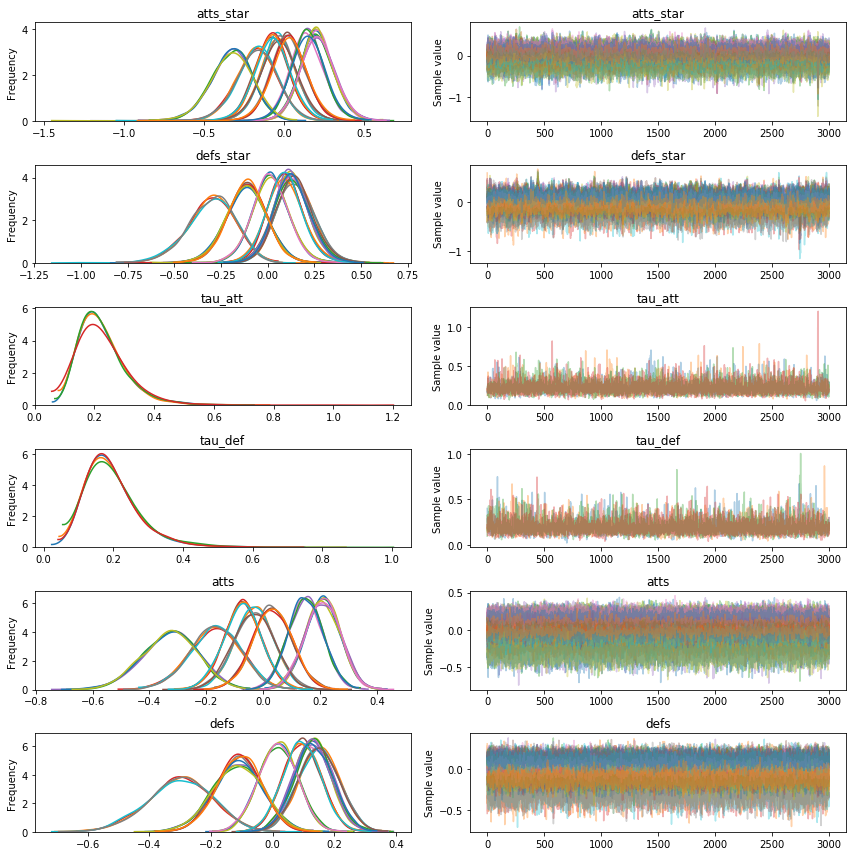

In [201]:
with base_model:
    trace = pm.sample(5000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

In [213]:
with pm.Model() as intercept_model:
    # global model parameters
    mu_att     = pm.Normal('mu_att', 0, 0.5)  # Distribution of mean, attack
    mu_def     = pm.Normal('mu_def', 0, 0.5)  # Distribution of mean, defense
    tau_att    = pm.HalfStudentT('tau_att', nu = 10, sd = 0.9) # Distribution of stdev, attack
    tau_def    = pm.HalfStudentT('tau_def', nu = 10, sd = 0.9) # Distribution of stdev, defense
    intercept  = pm.Flat('intercept')            # Tuneable intercept

    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = mu_att, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = mu_def, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(intercept + atts[player_1] + defs[player_2])
    p2_theta = tt.exp(intercept + atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, tau_def, tau_att, mu_def, mu_att]
Sampling 4 chains: 100%|██████████| 22000/22000 [04:17<00:00, 36.05draws/s] 
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


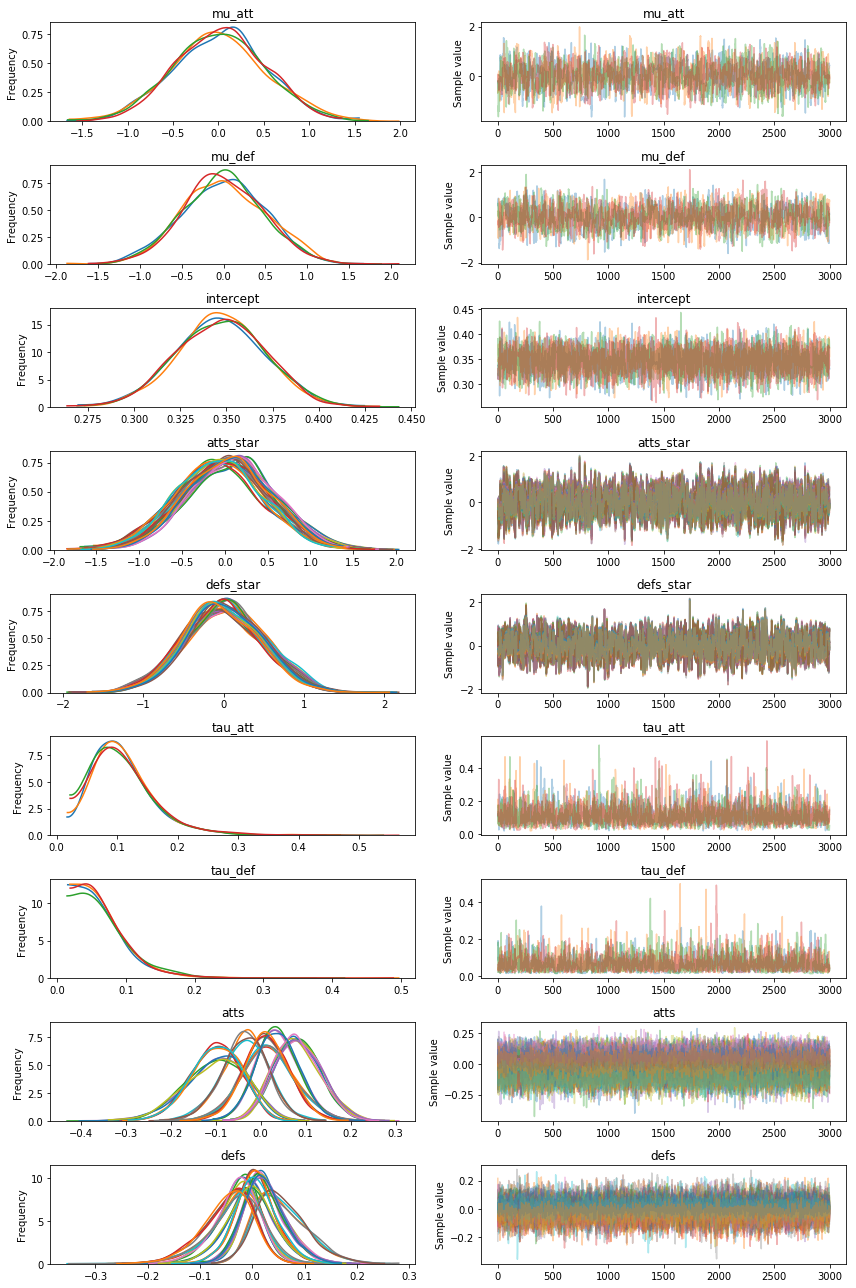

In [214]:
with intercept_model:
    trace = pm.sample(5000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

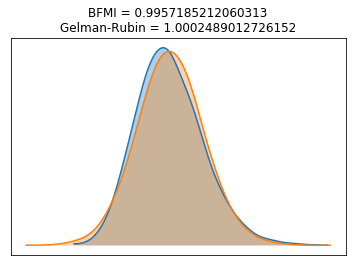

In [202]:
bfmi = pm.bfmi(burned_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(burned_trace).values())
(pm.energyplot(burned_trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

In [203]:
"""
with pm.Model() as check:
    gamma = pm.Gamma('gamma', 0.1, 0.1)
    student = pm.HalfStudentT('student', nu = 10, sd = 0.9)
    trace = pm.sample(5000)
    (pm.kdeplot(trace['student'])).set_title('student')
    (pm.kdeplot(trace['gamma'])).set_title('gamma')
"""

"\nwith pm.Model() as check:\n    gamma = pm.Gamma('gamma', 0.1, 0.1)\n    student = pm.HalfStudentT('student', nu = 10, sd = 0.9)\n    trace = pm.sample(5000)\n    (pm.kdeplot(trace['student'])).set_title('student')\n    (pm.kdeplot(trace['gamma'])).set_title('gamma')\n"

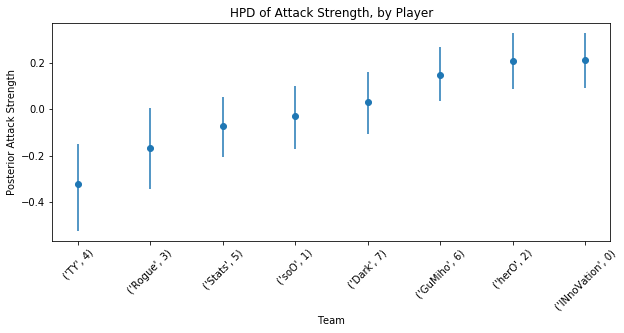

In [204]:
df_hpd = pd.DataFrame(pm.stats.hpd(burned_trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=players.values)
df_median = pd.DataFrame(pm.stats.quantiles(burned_trace['atts'])[50],
                         columns=['hpd_median'],
                         index=players.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Player')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

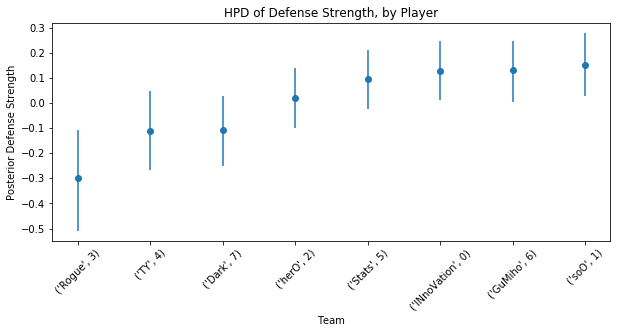

In [205]:
df_hpd = pd.DataFrame(pm.stats.hpd(burned_trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=players.values)
df_median = pd.DataFrame(pm.stats.quantiles(burned_trace['defs'])[50],
                         columns=['hpd_median'],
                         index=players.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defense Strength, by Player')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

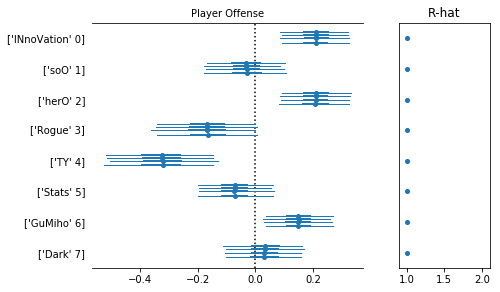

In [206]:
pm.forestplot(burned_trace, varnames=['atts'], ylabels=players.values, main="Player Offense")

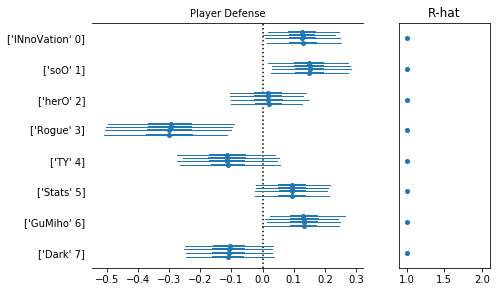

In [207]:
pm.forestplot(burned_trace, varnames=['defs'], ylabels=players.values, main="Player Defense")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d12937240>,
      dtype=object)

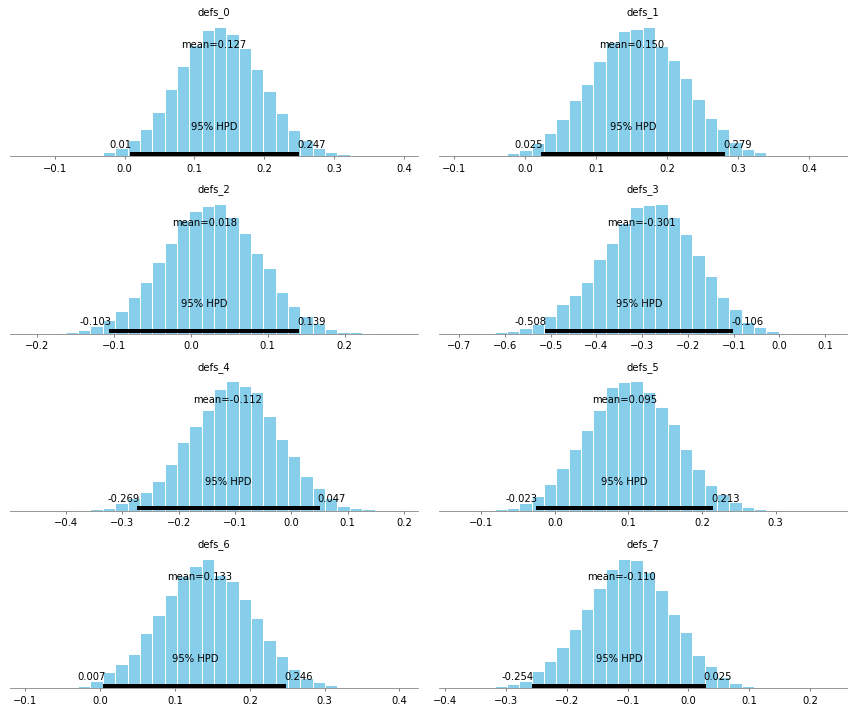

In [208]:
pm.plot_posterior(trace, varnames=['defs'])

In [209]:
with base_model:
    pp_trace = pm.sampling.sample_ppc(burned_trace)

100%|██████████| 3000/3000 [00:03<00:00, 905.16it/s]


In [210]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): home_won
        for i, home_won in enumerate(pp_trace['p1_points'] > pp_trace['p2_points'])
})
home_sim_df.insert(0, 'player', data['player_1'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): away_won
        for i, away_won in enumerate(pp_trace['p1_points'] < pp_trace['p2_points'])
})
away_sim_df.insert(0, 'player', data['player_2'])
sim_table = (home_sim_df.groupby('player')
                        .sum()
                        .add(away_sim_df.groupby('player')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='player', value_name='rank')
                        .groupby('player')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
player,,,,,,,,
Dark,0.061,0.192,0.392,0.727,1.130,0.487,0.011,0.000
GuMiho,0.466,0.743,0.782,0.620,0.297,0.091,0.001,0.000
INnoVation,0.251,0.508,0.717,0.793,0.573,0.156,0.002,0.000
Rogue,0.000,0.000,0.000,0.000,0.000,0.000,0.125,2.875
Stats,1.621,0.765,0.362,0.186,0.053,0.013,0.000,0.000
TY,0.000,0.000,0.000,0.000,0.008,0.157,2.763,0.072
herO,0.824,0.955,0.636,0.374,0.169,0.042,0.000,0.000
soO,0.002,0.021,0.085,0.235,0.676,1.877,0.104,0.000


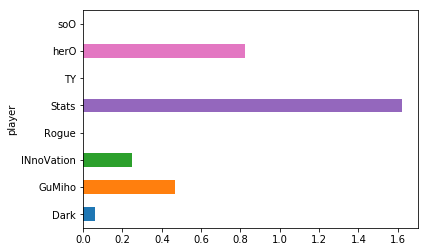

In [211]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

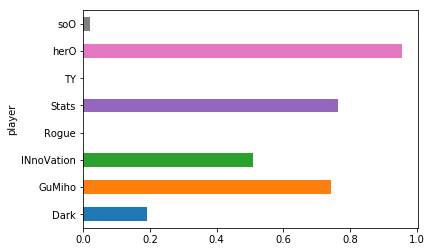

In [212]:
ax = sim_table.loc[:, 2.0].plot(kind='barh')